In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

#Transfer Learning model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

import matplotlib.pyplot as plt


Reduced train data shape: (2500, 32, 32, 3)
Reduced test data shape: (500, 32, 32, 3)


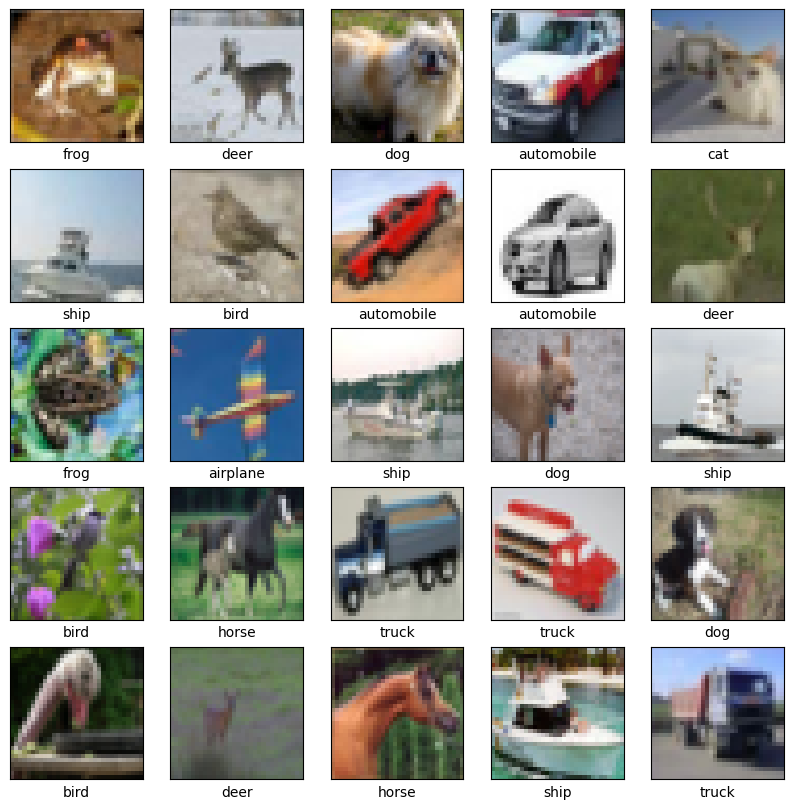

2023-09-05 14:43:26.877656: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-05 14:43:26.936648: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-05 14:43:26.936801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
# Load and preprocess the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Reduce the dataset to 1/20
x_train = x_train[::20]
y_train = y_train[::20]
x_test = x_test[::20]
y_test = y_test[::20]

print("Reduced train data shape:", x_train.shape)
print("Reduced test data shape:", x_test.shape)

def display_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i][0]])
    plt.show()

display_images(x_train, y_train)

# Resize and preprocess the images
x_train = tf.image.resize(x_train, (224, 224))  # Resize images to MobileNetV2 input size
x_test = tf.image.resize(x_test, (224, 224))
x_train = preprocess_input(x_train)  # Preprocess input data
x_test = preprocess_input(x_test)
y_train = to_categorical(y_train, num_classes=10)  # One-hot encode labels
y_test = to_categorical(y_test, num_classes=10)

In [ ]:
# Create a base MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Create a custom head for the model
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)
head_model = Dense(128, activation='relu')(head_model)
head_model = Dropout(0.5)(head_model)
output_layer = Dense(10, activation='softmax')(head_model)  # 10 classes for CIFAR-10

In [ ]:
# Create the transfer learning model
model = keras.models.Model(inputs=base_model.input, outputs=output_layer)

In [ ]:
# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {test_accuracy}')